### Notebook for `leiden` clustering of 6mpi cardiac leucocytes 

#### Environment: SCCAF

- **Developed by**: Alexandra Cirnu
- **Modified by**: Alexandra Cirnu
- **Talavera-López Lab - Würzburg Institute for Systems Immunology - Faculty of Medicine - Julius Maximilian Universität Würzburg**
- **Created on**: 240320
- **Last modified**: 240322

#### Load required modules

In [1]:
import SCCAF
from SCCAF import SCCAF_assessment, plot_roc
import scanpy as sc
import anndata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')
%matplotlib inline

-----
anndata     0.10.6
scanpy      1.9.8
-----
PIL                 10.2.0
SCCAF               NA
asttokens           NA
attr                23.2.0
comm                0.2.2
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0
debugpy             1.8.1
decorator           5.1.1
exceptiongroup      1.2.0
executing           2.0.1
h5py                3.10.0
igraph              0.11.4
ipykernel           6.29.3
ipywidgets          8.1.2
jedi                0.19.1
joblib              1.3.2
kiwisolver          1.4.5
leidenalg           0.10.2
llvmlite            0.42.0
louvain             0.8.2
matplotlib          3.8.3
mpl_toolkits        NA
natsort             8.4.0
numba               0.59.1
numexpr             2.9.0
numpy               1.26.4
packaging           24.0
pandas              2.2.1
parso               0.8.3
patsy               0.5.6
pickleshare         0.7.5
pkg_resources       NA
platformdirs        4.2.0
prompt_toolkit      3.0.42
psutil             

In [3]:
warnings.simplefilter(action = 'ignore')
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'

In [4]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 2,
)

#### Load data set

In [5]:
input = '/home/acirnu/data/ACM_cardiac_leuco/Test_scVI_ac240322.raw.h5ad'
adata = sc.read_h5ad(input)
adata

AnnData object with n_obs × n_vars = 44594 × 7000
    obs: 'sample', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 'total_counts-A4', 'n_cells_by_counts-B1', 'mean_counts-B1', 'pct_dropout_by_counts-B1', 'total_counts-B1', 'n_cells_by_counts-B2', 'mean_counts-B2', 'pct_dropout_by_counts-B2', 'total_counts-B2', 'highly_variable', 'highly_variabl

Extract raw counts

In [6]:
adata = adata.raw.to_adata()
adata

AnnData object with n_obs × n_vars = 44594 × 32285
    obs: 'sample', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 'total_counts-A4', 'n_cells_by_counts-B1', 'mean_counts-B1', 'pct_dropout_by_counts-B1', 'total_counts-B1', 'n_cells_by_counts-B2', 'mean_counts-B2', 'pct_dropout_by_counts-B2', 'total_counts-B2'
    uns: '_scvi_manager_uuid', '_s

Save raw counts

In [7]:
adata.raw = adata

#### Normalize and log transform data (modify adata.X), raw counts are still stored in adata.raw

In [8]:
sc.pp.normalize_total(adata, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Mapkapk2', 'Il1b', 'Cst3', 'Fabp5', 'Fabp4', 'S100a8', 'S100a9', 'Prdx1', 'Cxcl2', 'Spp1', 'Myl2', 'Actb', 'Igkc', 'Apoe', 'Ftl1', 'Hbb-bt', 'Hbb-bs', 'Camp', 'Ngp', 'Lyz2', 'Hba-a1', 'Hba-a2', 'Ccl8', 'Ccl5', 'Ccl3', 'Ccl4', 'Igha', 'Ighg2c', 'Ighm', 'Ctla2a', 'Cma1', 'Mcpt4', 'Iglc1', 'Iglc2', 'Retnla', 'Retnlg', 'Cmss1', 'Gm26917', 'Gm42418', 'Cd74', 'Malat1', 'Fth1', 'Tmsb4x', 'mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp6', 'mt-Co3', 'mt-Nd4', 'mt-Cytb']
    finished (0:00:00)


#### Perform leiden clustering with resolution 0.1 and assess with SCCAF

running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:30)
Mean CV accuracy: 0.9889
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.9819


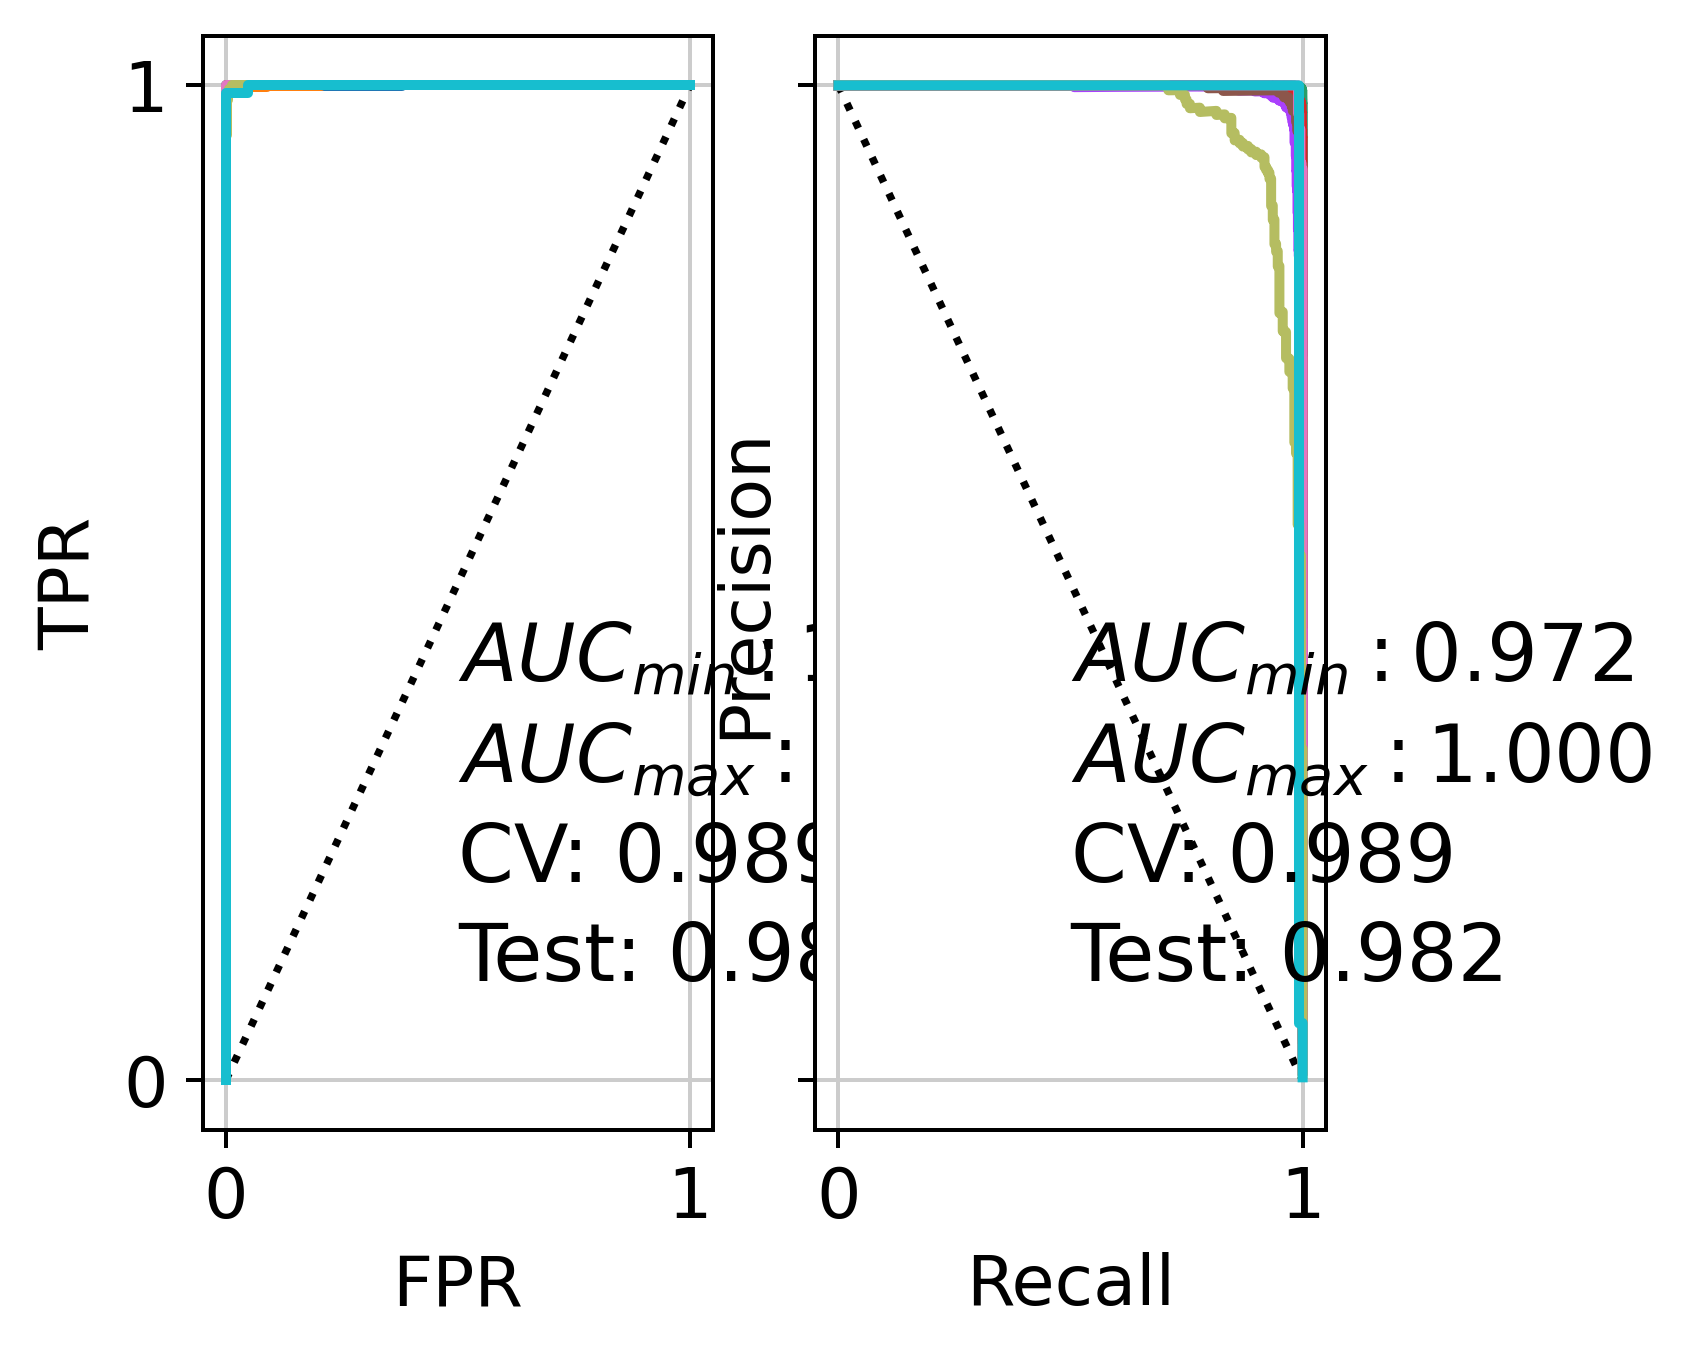

In [9]:
#Plotting code
sc.tl.leiden(adata, resolution = 0.1, random_state = 1786)
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata.X, adata.obs['leiden'], n = 100)
plot_roc(y_prob, y_test, clf, cvsm = cvsm, acc = acc)

# Reset all Matplotlib parameters to their defaults
plt.rcParams.update(plt.rcParamsDefault)

#Show plot
sc.set_figure_params(dpi=300)
plt.rcParams["figure.figsize"] = (1,1)
plt.show()

#### Perform leiden clustering with resolution 0.2 and assess with SCCAF

In [10]:
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')
%matplotlib inline

running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:42)
Mean CV accuracy: 0.9692
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.9283


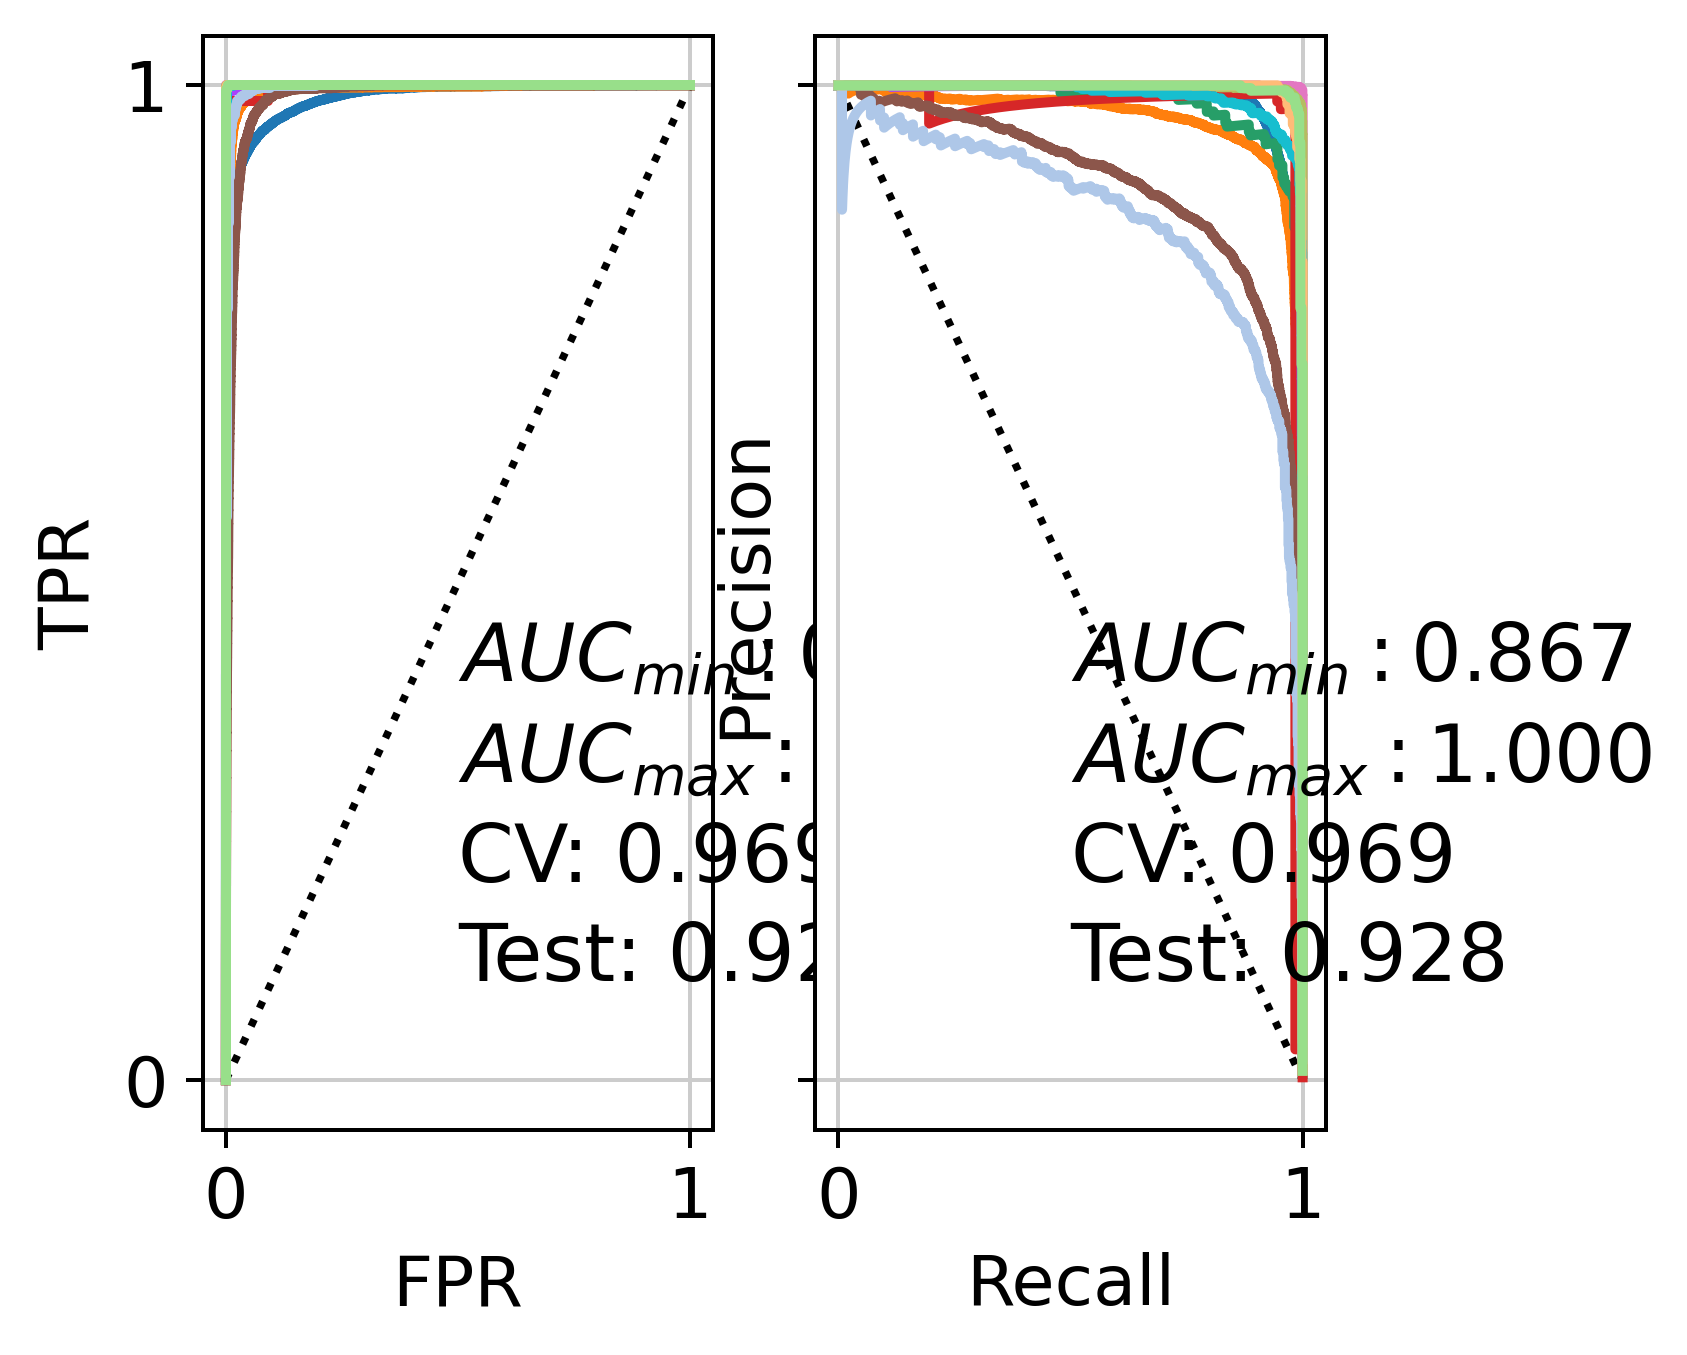

In [11]:
#Plotting code
sc.tl.leiden(adata, resolution = 0.2, random_state = 1786)
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata.X, adata.obs['leiden'], n = 100)
plot_roc(y_prob, y_test, clf, cvsm = cvsm, acc = acc)

# Reset all Matplotlib parameters to their defaults
plt.rcParams.update(plt.rcParamsDefault)

#Show plot
sc.set_figure_params(dpi=300)
plt.rcParams["figure.figsize"] = (1,1)
plt.show()

#### Perform leiden clustering with resolution 0.3 and assess with SCCAF

In [12]:
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')
%matplotlib inline

running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:44)
Mean CV accuracy: 0.9477
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.9297


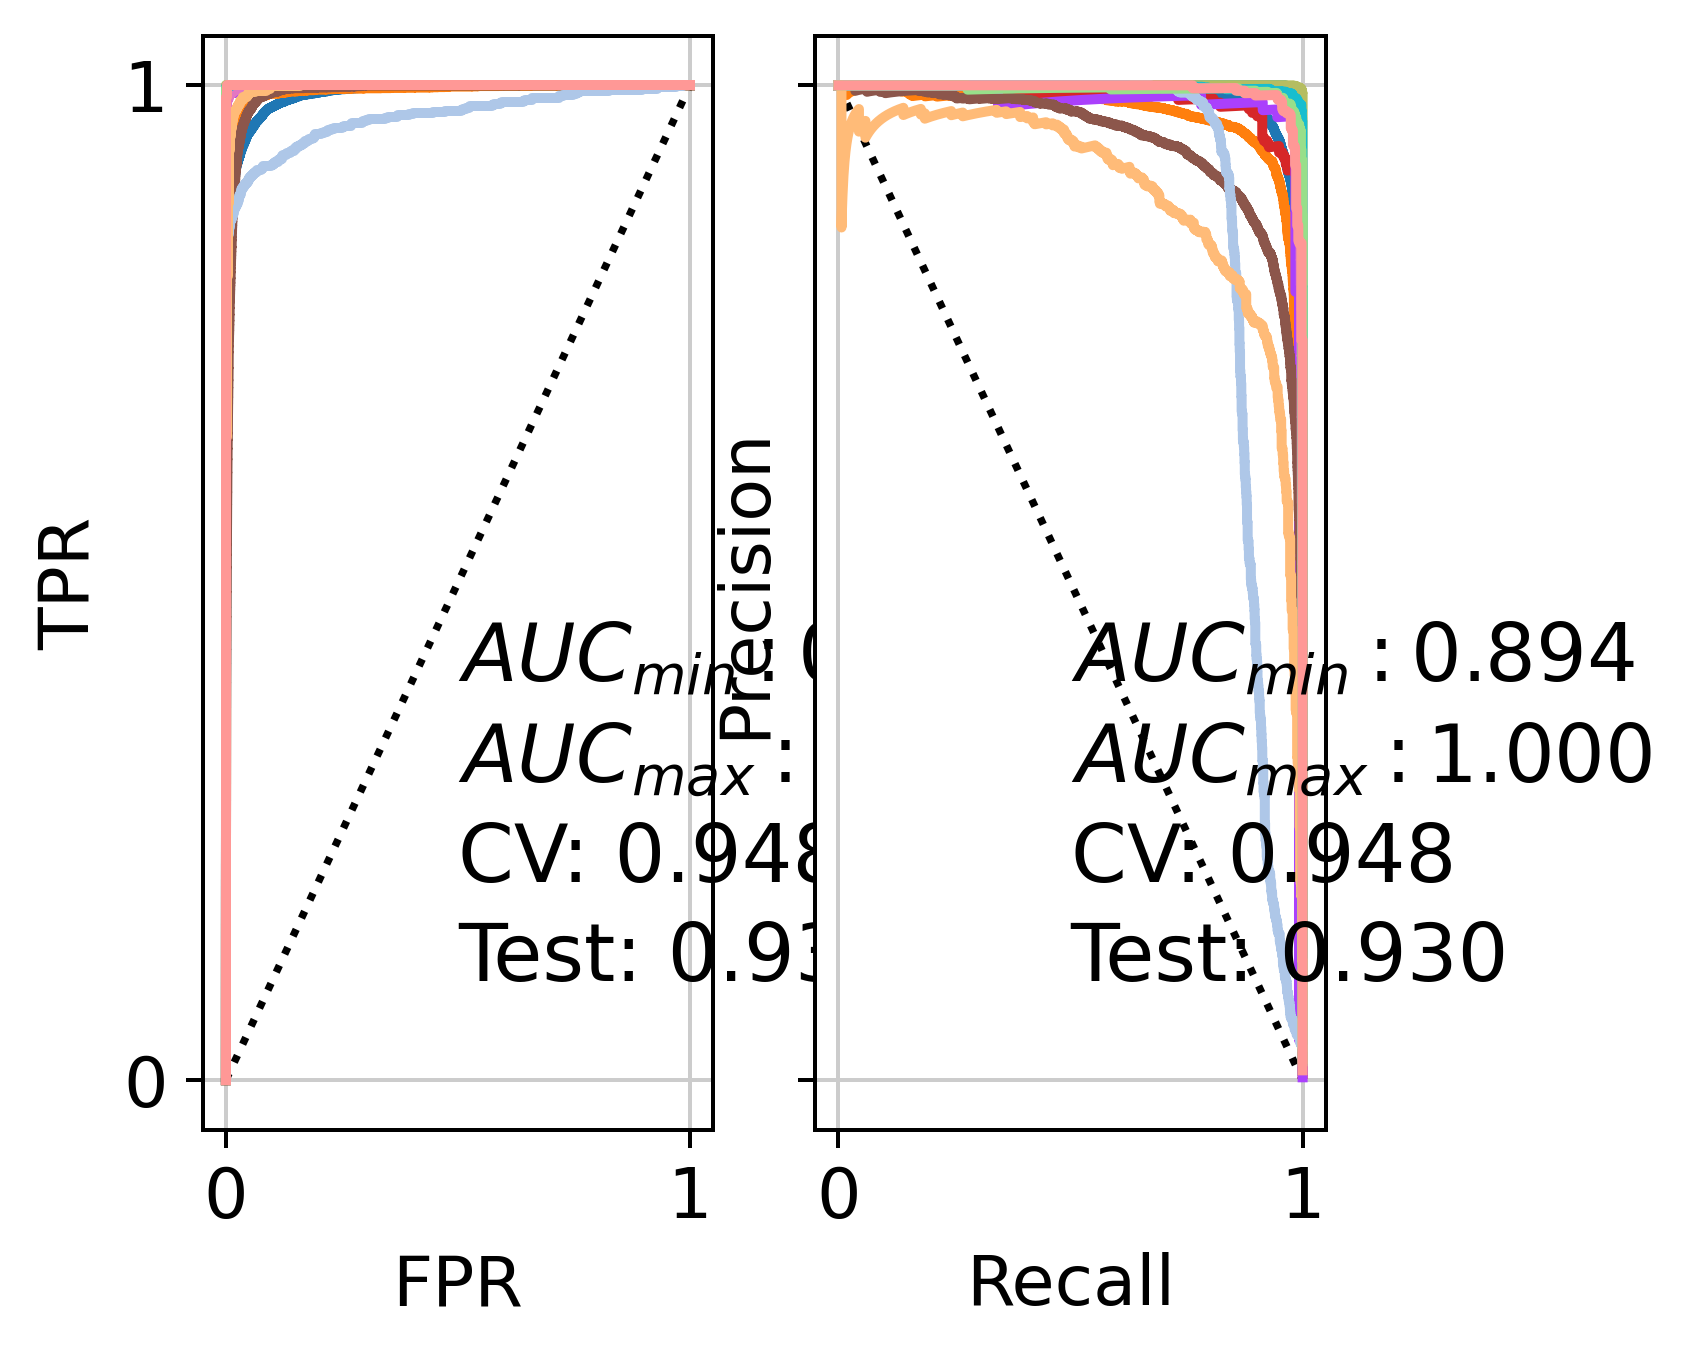

In [13]:
#Plotting code
sc.tl.leiden(adata, resolution = 0.3, random_state = 1786)
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata.X, adata.obs['leiden'], n = 100)
plot_roc(y_prob, y_test, clf, cvsm = cvsm, acc = acc)

# Reset all Matplotlib parameters to their defaults
plt.rcParams.update(plt.rcParamsDefault)

#Show plot
sc.set_figure_params(dpi=300)
plt.rcParams["figure.figsize"] = (1,1)
plt.show()

#### Perform leiden clustering with resolution 0.4 and assess with SCCAF

In [14]:
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')
%matplotlib inline

running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:47)
Mean CV accuracy: 0.9607
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.9434


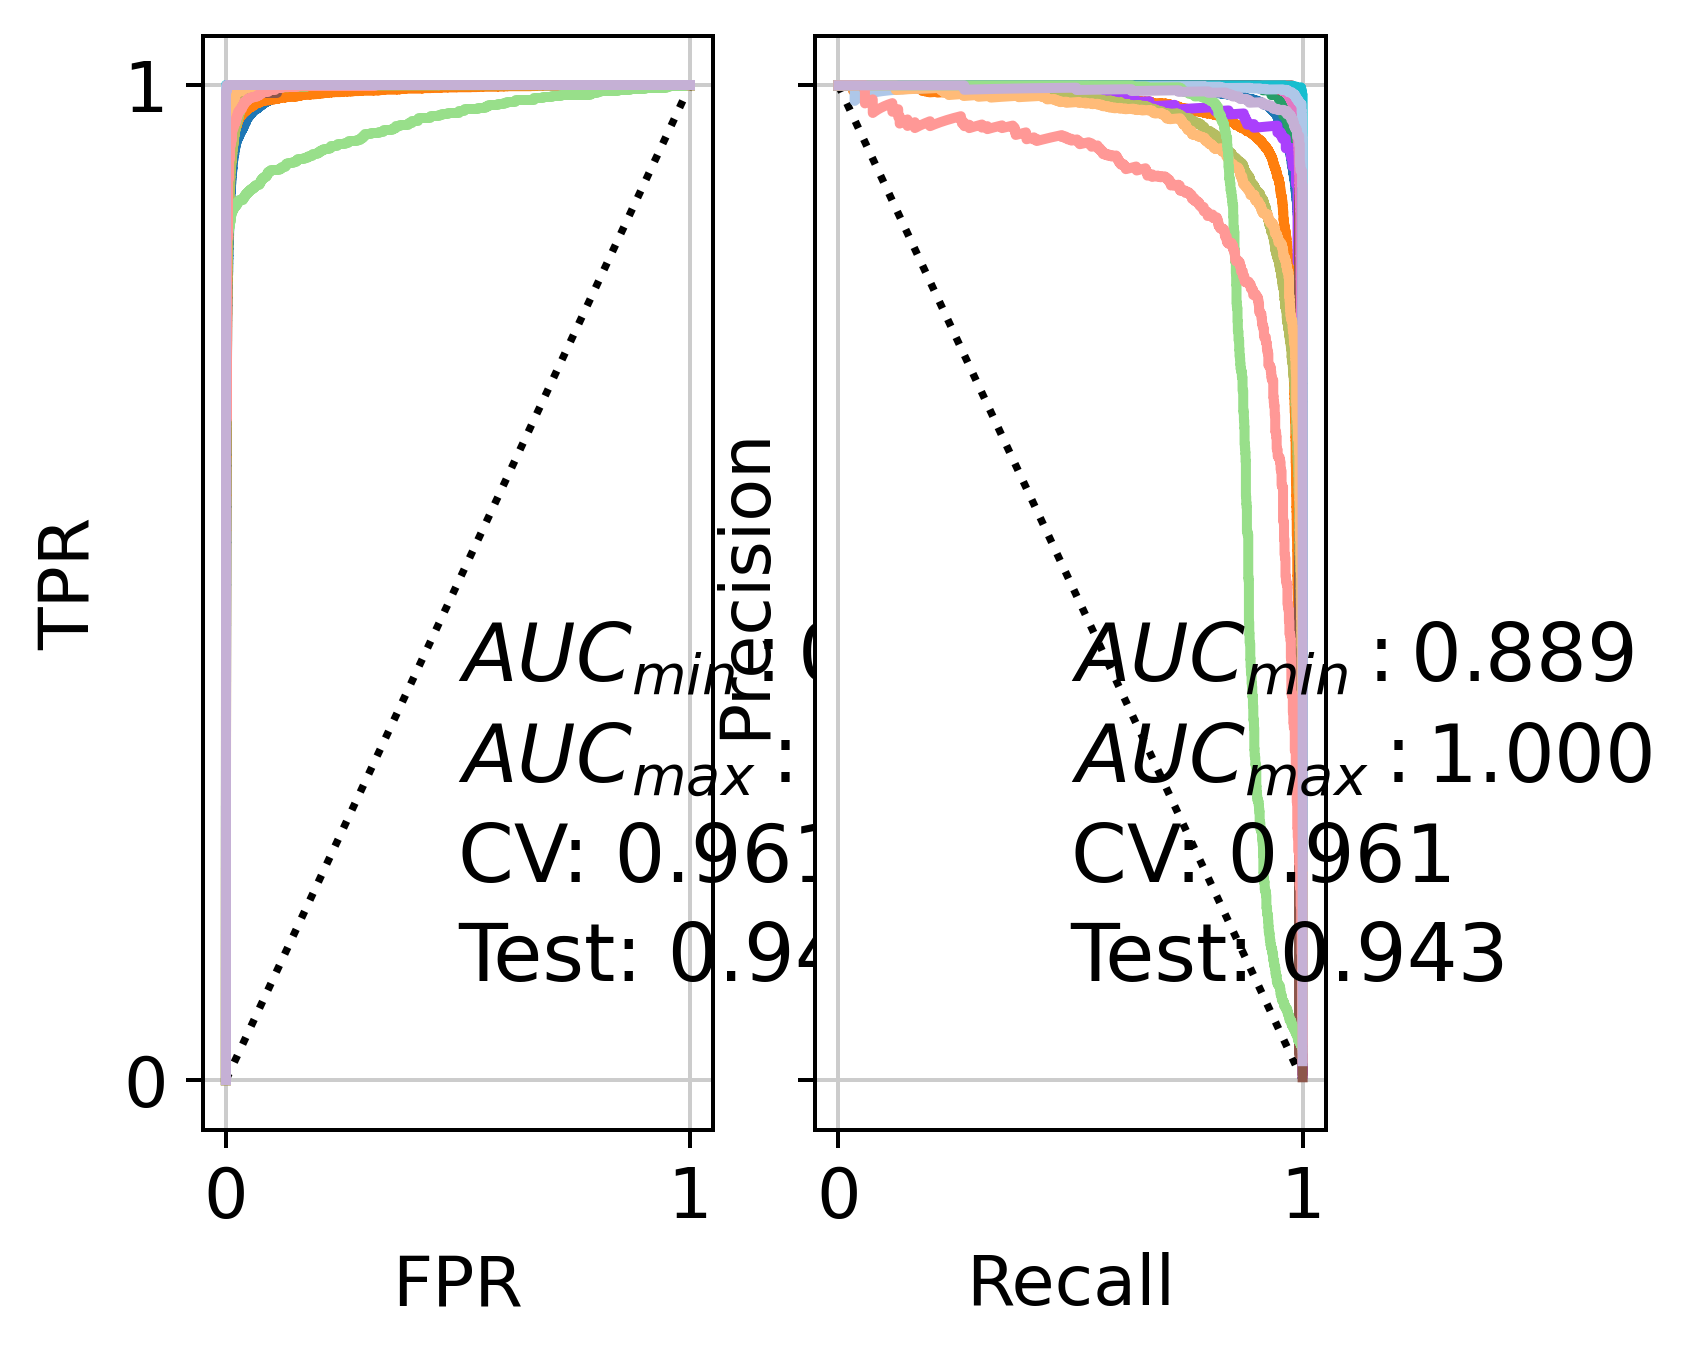

In [15]:
#Plotting code
sc.tl.leiden(adata, resolution = 0.4, random_state = 1786)
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata.X, adata.obs['leiden'], n = 100)
plot_roc(y_prob, y_test, clf, cvsm = cvsm, acc = acc)

# Reset all Matplotlib parameters to their defaults
plt.rcParams.update(plt.rcParamsDefault)

#Show plot
sc.set_figure_params(dpi=300)
plt.rcParams["figure.figsize"] = (1,1)
plt.show()

#### Perform leiden clustering with resolution 0.5 and assess with SCCAF

In [16]:
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')
%matplotlib inline

running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:01:00)
Mean CV accuracy: 0.9256
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.8561


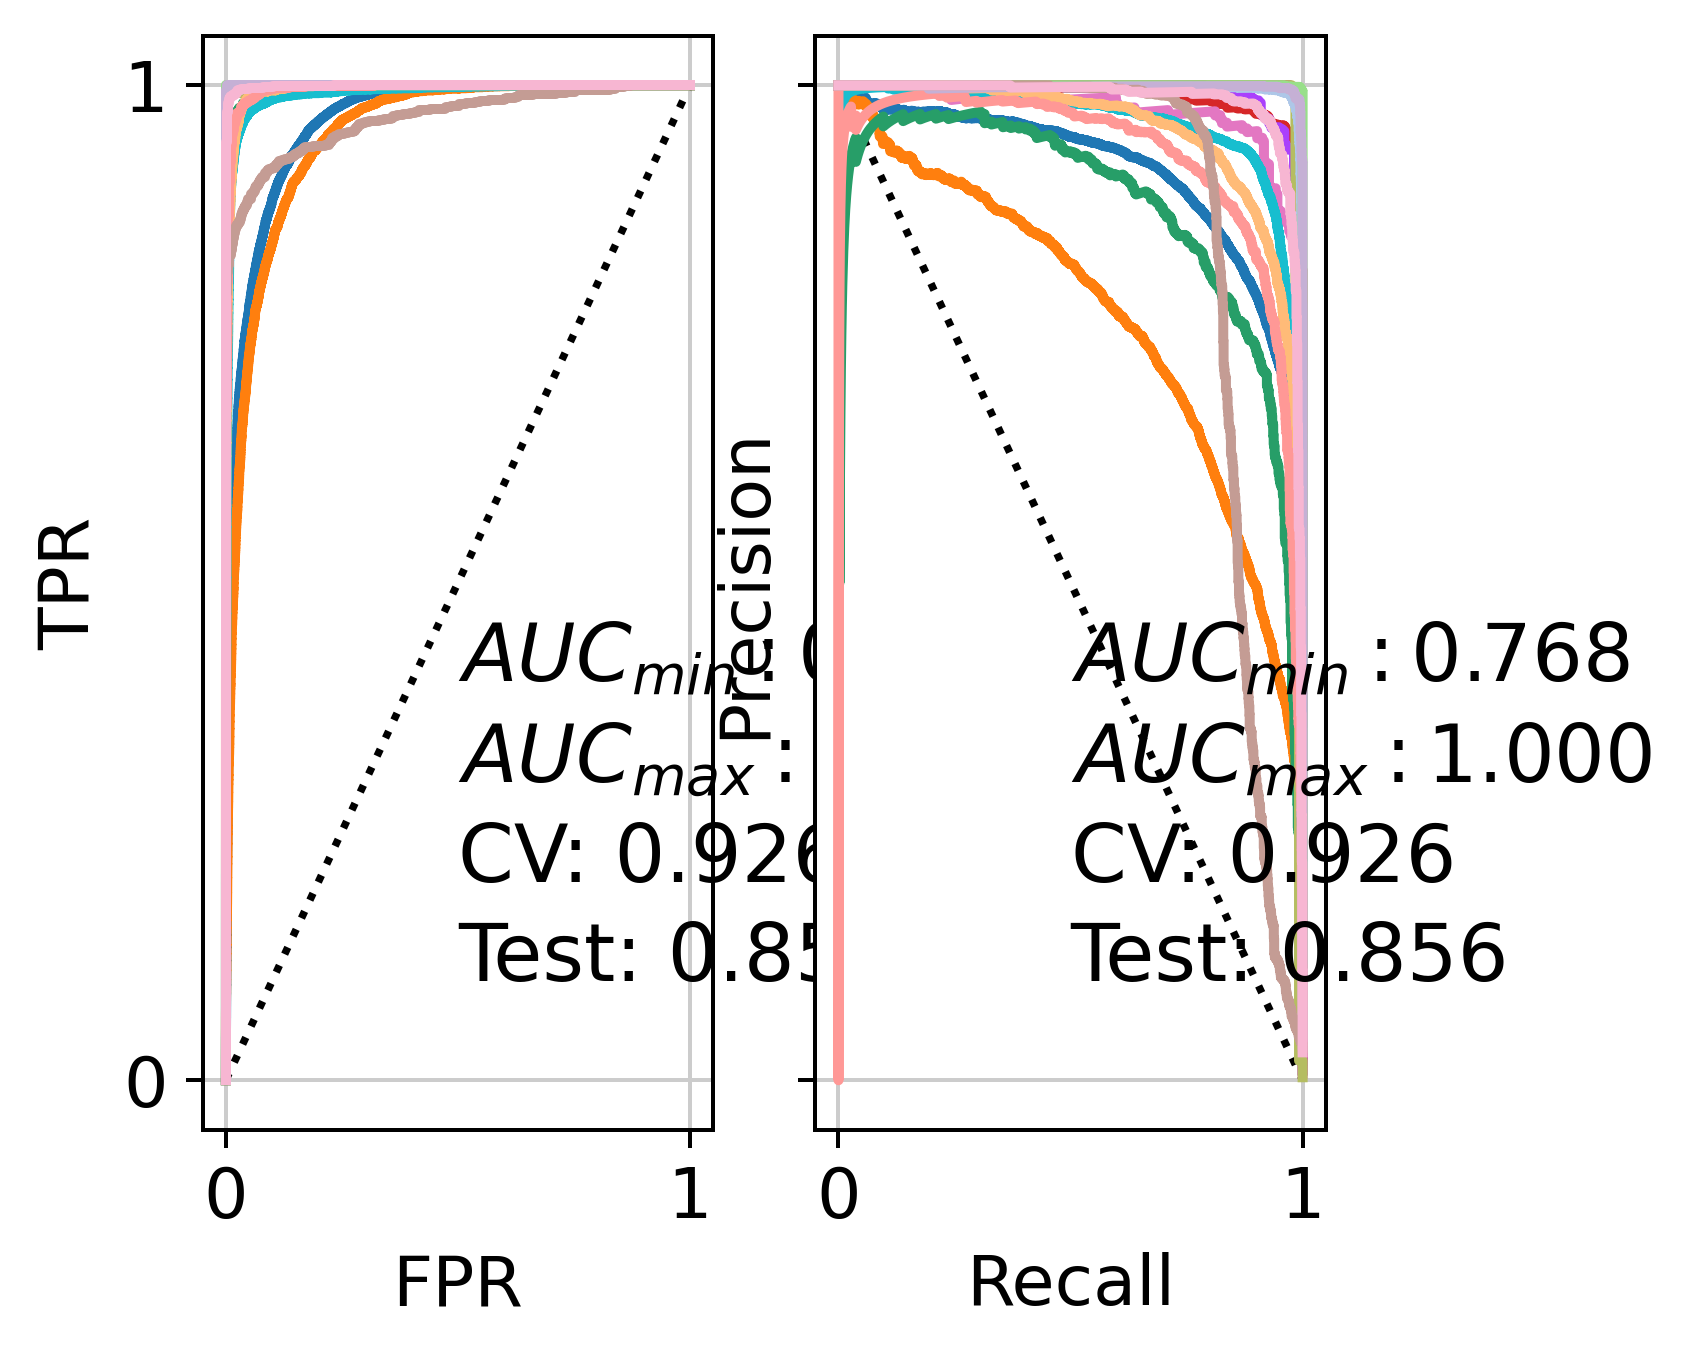

In [17]:
#Plotting code
sc.tl.leiden(adata, resolution = 0.5, random_state = 1786)
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata.X, adata.obs['leiden'], n = 100)
plot_roc(y_prob, y_test, clf, cvsm = cvsm, acc = acc)

# Reset all Matplotlib parameters to their defaults
plt.rcParams.update(plt.rcParamsDefault)

#Show plot
sc.set_figure_params(dpi=300)
plt.rcParams["figure.figsize"] = (1,1)
plt.show()

#### Perform leiden clustering with resolution 0.6 and assess with SCCAF

In [18]:
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')
%matplotlib inline

running Leiden clustering
    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:57)
Mean CV accuracy: 0.8859
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.8333


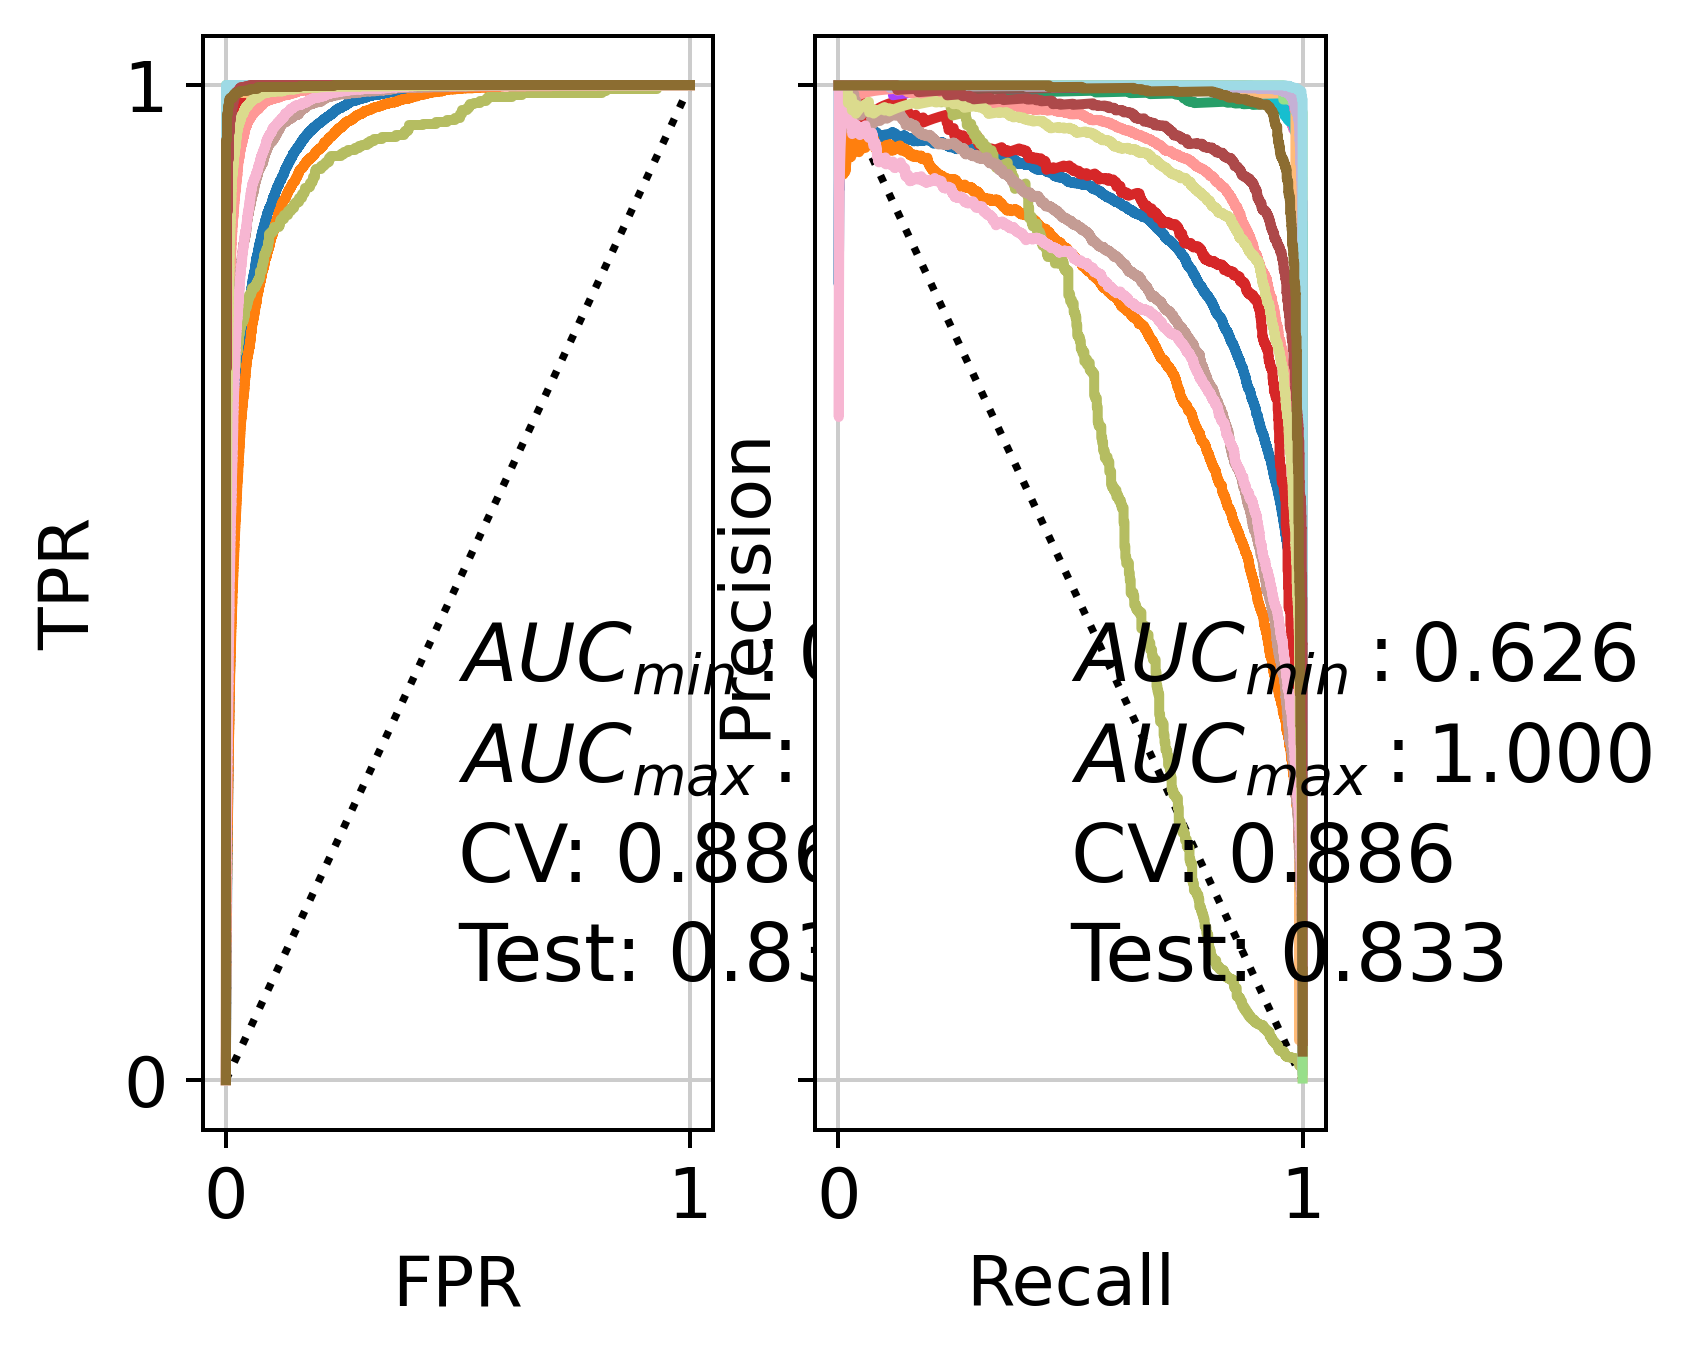

In [19]:
#Plotting code
sc.tl.leiden(adata, resolution = 0.6, random_state = 1786)
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata.X, adata.obs['leiden'], n = 100)
plot_roc(y_prob, y_test, clf, cvsm = cvsm, acc = acc)

# Reset all Matplotlib parameters to their defaults
plt.rcParams.update(plt.rcParamsDefault)

#Show plot
sc.set_figure_params(dpi=300)
plt.rcParams["figure.figsize"] = (1,1)
plt.show()

### Choose Resolution for `leiden` clustering
Chosen: 0.1 (as I want only a very general clustering)

In [20]:
sc.tl.leiden(adata, resolution = 0.1, random_state = 1786)

running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:30)


Save results

In [21]:
#Save the results
adata.write_h5ad('/home/acirnu/data/ACM_cardiac_leuco/Test_scVI_leiden_ac240322.raw.h5ad')